In [1]:
!git clone https://github.com/routsourav1729/CUB_200_2011.git


Cloning into 'CUB_200_2011'...
remote: Enumerating objects: 12210, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 12210 (delta 5), reused 13 (delta 2), pack-reused 12191
Receiving objects: 100% (12210/12210), 1.07 GiB | 36.50 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (11795/11795), done.


In [2]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=4792c2cf3e1e19c1691f407a31f680d0dec2a49a5a2f148dfcc8140c1190ae70
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt

# Assuming CUB-200-2011 has 200 classes
num_classes = 200
batch_size = 32
num_epochs = 20
learning_rate = 0.0001

# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=299, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=30),
        transforms.RandomRotation(degrees=45),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=299),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=299),
        transforms.CenterCrop(size=299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root='/content/CUB_200_2011/train', transform=image_transforms['train']),
    'test':
    datasets.ImageFolder(root='/content/CUB_200_2011/test', transform=image_transforms['test']),
}

# Dataloader iterators, make sure to shuffle

train_loader = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data['test'], batch_size=batch_size, shuffle=False)




In [7]:
model = models.efficientnet_b1(weights='IMAGENET1K_V1')
model.classifier[1] = nn.Linear(1280, 200)


total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 148MB/s]

6,769,384 total parameters.
6,769,384 training parameters.


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
import os

In [15]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)

checkpointCount = 1
training_loss_list = []
training_accuracy_list = []

# Training the model
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    training_loss_list.append(epoch_loss)
    training_accuracy_list.append(epoch_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')

    # Saving checkpoint after each epoch
    parent_dir = '/content/CUB_200_2011'
    path_f = os.path.join(parent_dir, 'CheckPoints')
    os.makedirs(path_f, exist_ok=True)
    checkPath = os.path.join(path_f, 'CheckPoint'+str(checkpointCount))

    torch.save(model.state_dict(), checkPath)

    checkpointCount += 1


print('Finished Training')

Epoch [1/20], Loss: 4.8455, Train Accuracy: 8.98%
Epoch [2/20], Loss: 3.4656, Train Accuracy: 33.13%
Epoch [3/20], Loss: 2.4529, Train Accuracy: 52.25%
Epoch [4/20], Loss: 1.7988, Train Accuracy: 65.17%
Epoch [5/20], Loss: 1.3607, Train Accuracy: 73.04%
Epoch [6/20], Loss: 1.0712, Train Accuracy: 78.06%
Epoch [7/20], Loss: 0.8639, Train Accuracy: 82.37%
Epoch [8/20], Loss: 0.7111, Train Accuracy: 85.54%
Epoch [9/20], Loss: 0.5888, Train Accuracy: 87.72%
Epoch [10/20], Loss: 0.4951, Train Accuracy: 89.47%
Epoch [11/20], Loss: 0.4121, Train Accuracy: 91.84%
Epoch [12/20], Loss: 0.3488, Train Accuracy: 92.91%
Epoch [13/20], Loss: 0.2978, Train Accuracy: 94.24%
Epoch [14/20], Loss: 0.2608, Train Accuracy: 94.88%
Epoch [15/20], Loss: 0.2219, Train Accuracy: 95.98%
Epoch [16/20], Loss: 0.1999, Train Accuracy: 96.41%
Epoch [17/20], Loss: 0.1750, Train Accuracy: 96.76%
Epoch [18/20], Loss: 0.1488, Train Accuracy: 97.35%
Epoch [19/20], Loss: 0.1339, Train Accuracy: 97.55%
Epoch [20/20], Loss: 0

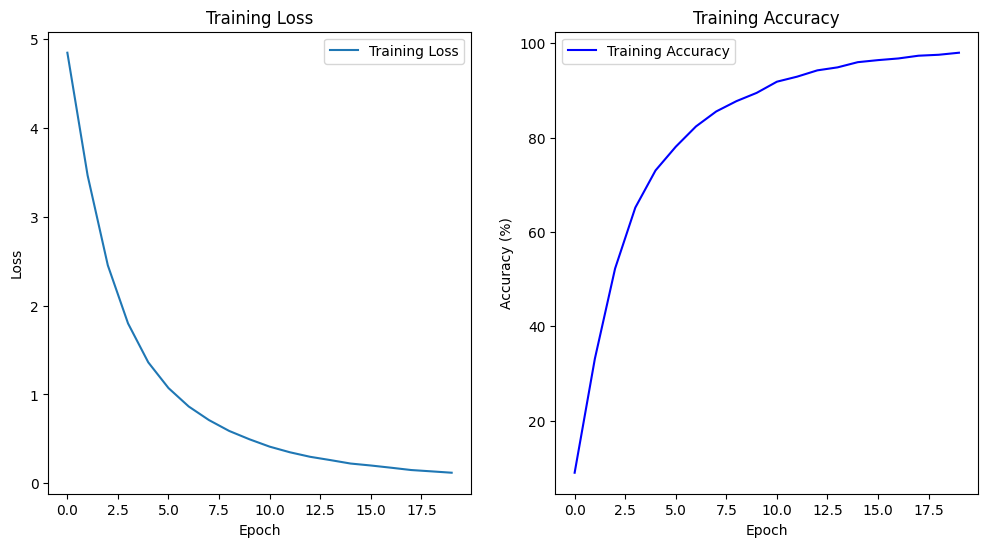

In [18]:
# Plotting Graphs training loss and training accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracy_list, label='Training Accuracy', c='b')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.show()

In [25]:
# Testing the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        count = 1
    print(f'Test Accuracy: {100 * correct / total}%')


Test Accuracy: 80.73869520193304%


**Testing from saved weights**

In [26]:
# Initialize EfficientNet B1
model_test = models.efficientnet_b1(weights='IMAGENET1K_V1')

model_test.classifier[1] = nn.Linear(1280, 200)

total_params = sum(p.numel() for p in model_test.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in model_test.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

6,769,384 total parameters.
6,769,384 training parameters.


In [27]:
model_weights_path = '/content/drive/MyDrive/train_test_split/CheckPoint20'

# Load the state_dict of the B0 model
b0_state_dict = torch.load(model_weights_path)

# Load with strict=False to ignore incompatible keys
model_test.load_state_dict(b0_state_dict, strict=False)


<All keys matched successfully>

In [29]:
# Assuming test_loader is already defined
model_test.eval()  # Set the model to evaluation mode
correct = 0
total = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_test.to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_test(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy from loading saved checkpoint 20: {accuracy}%')

Test Accuracy from loading saved checkpoint 20: 80.73869520193304%


In [23]:
import shutil

# Source path on Google Drive (mounted in Colab)
source_path = '/content/CUB_200_2011/CheckPoints/CheckPoint20'

# Destination path in Colab environment
destination_path = '/content/drive/MyDrive/train_test_split'

# Copy the file from Google Drive to Colab
shutil.copy(source_path, destination_path)

print("Checkpoint downloaded successfully.")


Checkpoint downloaded successfully.
